In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import closing
from arcos4py.tools import track_events_image, remove_image_background
from arcos4py.tools._detect_events import upscale_image
from arcos4py.tools._cleandata import blockwise_median
from skimage import io
from scipy.ndimage import distance_transform_edt
import napari
from skimage.filters import gaussian
from skimage.measure import regionprops_table
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate, correlation_lags

In [2]:
from cellpose import models

In [3]:
def drop_scattered_small_labels(label_image, min_size=100):
    """
    Removes small scattered regions of each label from a labeled image.

    Parameters:
    - label_image: 2D numpy array representing the labeled image.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed image with small scattered labels dropped.
    """
    label_image = closing(label_image)
    unique_labels = np.unique(label_image)
    output_image = np.zeros_like(label_image)

    for label in unique_labels:
        if label == 0:  # Assuming 0 is the background
            continue

        # Create a binary image for the current label
        binary_mask = label_image == label

        # Identify separate regions of the current label
        labeled_mask, num_features = ndimage.label(binary_mask)

        # Measure the size of each region
        sizes = ndimage.sum(binary_mask, labeled_mask, range(num_features + 1))

        # Create a mask of regions to be kept for the current label
        mask_size = sizes >= min_size
        keep = mask_size[labeled_mask]

        # Update the output image with regions of the current label that are kept
        output_image[keep] = label

    return output_image


def process_time_series_label_images(time_series_label_images, min_size=100):
    """
    Processes a time-series of label images by removing small scattered labels.

    Parameters:
    - time_series_label_images: 3D numpy array representing a time-series of labeled images.
      The first dimension is time.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed time-series with small scattered labels dropped from each frame.
    """

    # Get the number of time points
    T = time_series_label_images.shape[0]

    # Initialize an output array of the same shape as the input
    output_images = np.zeros_like(time_series_label_images)

    for t in range(T):
        output_images[t] = drop_scattered_small_labels(time_series_label_images[t], min_size=min_size)

    return output_images


def match_histogram(source, template):
    hist_source, bin_edges = np.histogram(source.ravel(), bins=65536, range=(0, 65536))
    hist_template, _ = np.histogram(template.ravel(), bins=65536, range=(0, 65536))

    cdf_source = hist_source.cumsum() / hist_source.sum()
    cdf_template = hist_template.cumsum() / hist_template.sum()

    lookup_table = np.zeros(65536, dtype=np.uint16)
    j = 0
    for i in range(65536):
        while cdf_template[j] < cdf_source[i] and j < 65535:
            j += 1
        lookup_table[i] = j

    matched = lookup_table[source]
    return matched


def match_histogram_stack(img_stack, template):
    matched_stack = np.zeros_like(img_stack)
    for i in range(img_stack.shape[0]):
        matched_stack[i] = match_histogram(img_stack[i], template)
    return matched_stack

def filter_by_duration(labeled_stack, min_duration):
    """
    Removes tracks from a labeled image stack if their duration is less than the specified minimum.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        # If the duration is less than min_duration, remove the track
        if len(time_points) < min_duration:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack

In [5]:
ref52 = io.imread("transfer_187559_files_94515bab/REF52_noc_1v2000_myo_rhoa_actin_crop.tif")

In [6]:
ref52.shape

(500, 340, 360, 3)

In [7]:
from tqdm.auto import tqdm

myosin_bl = []
rGBD_bl = []
actin_bl = []

myosin = ref52[..., 1]
rGBD = ref52[..., 2]
actin = ref52[..., 0]
reference_myosin = myosin[0]
reference_rGBD = rGBD[0]
reference_actin = actin[0]
myosin_bl.append(np.stack([match_histogram(img, reference_myosin) for img in tqdm(myosin)]))
rGBD_bl.append(np.stack([match_histogram(img, reference_rGBD) for img in tqdm(rGBD)]))
actin_bl.append(np.stack([match_histogram(img, reference_actin) for img in tqdm(actin)]))
myosin_bl = np.concatenate(myosin_bl)
rGBD_bl = np.concatenate(rGBD_bl)
actin_bl = np.concatenate(actin_bl)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
viewer = napari.Viewer()
viewer.add_image(myosin)

<Image layer 'myosin' at 0x7fe492faa550>

In [26]:
binned_myosin = blockwise_median(myosin, (1, 2, 2))

In [27]:
viewer = napari.Viewer()
viewer.add_image(binned_myosin)

<Image layer 'binned_myosin' at 0x7fe49ebb7ee0>

In [28]:
model = models.Cellpose(gpu=True, model_type="cyto2")

In [29]:
seg_cp = np.zeros_like(binned_myosin)

In [30]:
for idx, img in enumerate(binned_myosin):
    masks, flows, styles, diams = model.eval(img, diameter=60, channels=[0, 0], do_3D=False, net_avg=True)
    seg_cp[idx] = masks

In [31]:
viewer = napari.Viewer()
viewer.add_image(seg_cp)

<Image layer 'seg_cp' at 0x7fe51a2ecc40>

In [32]:
dist_transform = []
for i in seg_cp:
    dist_transform.append(distance_transform_edt(i).astype(np.uint16))

dist_transform = np.stack(dist_transform)
viewer = napari.Viewer()
viewer.add_image(dist_transform)

<Image layer 'dist_transform' at 0x7fe490720790>

In [33]:
myosin_bg = remove_image_background(binned_myosin, size=(100, 1, 1), filter_type="median", crop_time_axis=True)
myosin_bg = np.where(myosin_bg < 0, 0, myosin_bg)

In [34]:
test = gaussian(myosin_bg, sigma=1)

In [35]:
test_no_edge = np.where((dist_transform[50:-50] < 5), 0, test)

In [36]:
events_1 = track_events_image(test_no_edge > 40, eps=3, epsPrev=3, minClSz=8, predictor=True, nPrev=3, downsample=1)

100%|██████████| 400/400 [00:06<00:00, 61.22it/s]


In [41]:
viewer = napari.Viewer()
viewer.add_image(events_1)

<Image layer 'events_1' at 0x7fe51ba6dac0>

In [38]:
events_1_filtered = process_time_series_label_images(events_1, 5)
events_1_filtered = filter_by_duration(events_1_filtered, 10)

In [54]:
events_upscaled = []
for t in events_1_filtered:
    t_img = upscale_image(t, 2)
    events_upscaled.append(t_img)

events_upscaled = np.stack(events_upscaled)

In [55]:
viewer = napari.Viewer()
viewer.add_image(events_upscaled)

<Image layer 'events_upscaled' at 0x7fe49f87ea60>

In [49]:
reshaped_ref52 = ref52[50:-50]

In [52]:
ref52.shape

(500, 340, 360, 3)

In [57]:
label_image.shape

(340, 360)

In [58]:
df_all = []

middle_frame = 300
label_image = events_upscaled[middle_frame] == 16
min_frame_range = middle_frame - 50
max_frame_range = middle_frame + 50
intensity_image = ref52[min_frame_range:max_frame_range]
for idx, e in enumerate(intensity_image):
    props = regionprops_table(label_image.astype(int), properties=("label", "area", "centroid", 'intensity_mean'), intensity_image=e[:, :1160])
    df_temp = pd.DataFrame(props)
    df_temp["frame"] = idx -10
    df_all.append(df_temp)

df_all_concat = pd.concat(df_all)

<Axes: xlabel='frame'>

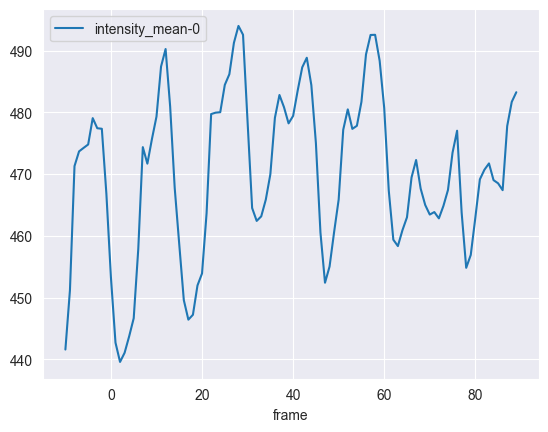

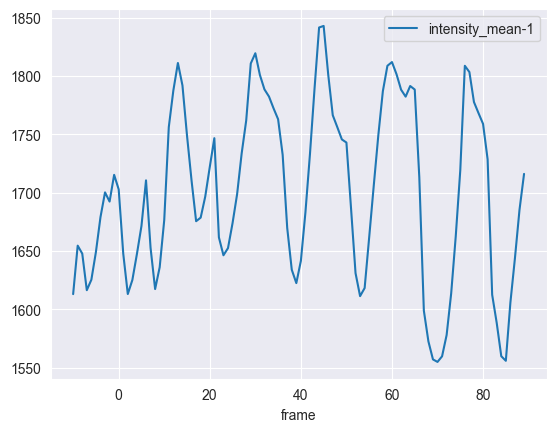

In [59]:
df_all_concat.plot(x='frame', y='intensity_mean-0')
df_all_concat.plot(x='frame', y='intensity_mean-1')

In [60]:
import pandas as pd
from skimage.measure import regionprops_table

df_all_several_frames = []

for middle_frame in range(300, 399, 1):  
    label_image = events_upscaled[middle_frame] == 16
    min_frame_range = middle_frame - 50
    max_frame_range = middle_frame + 50
    intensity_image = ref52[min_frame_range:max_frame_range]

    for idx, e in enumerate(intensity_image):
        props = regionprops_table(label_image.astype(int), properties=("label", "area", "centroid", 'intensity_mean'), intensity_image=e[:, :1160])
        df_temp_several_frames = pd.DataFrame(props)
        df_temp_several_frames["frame"] = idx - 10
        df_all_several_frames.append(df_temp_several_frames)

df_all_several_frames = pd.concat(df_all_several_frames, ignore_index=True)

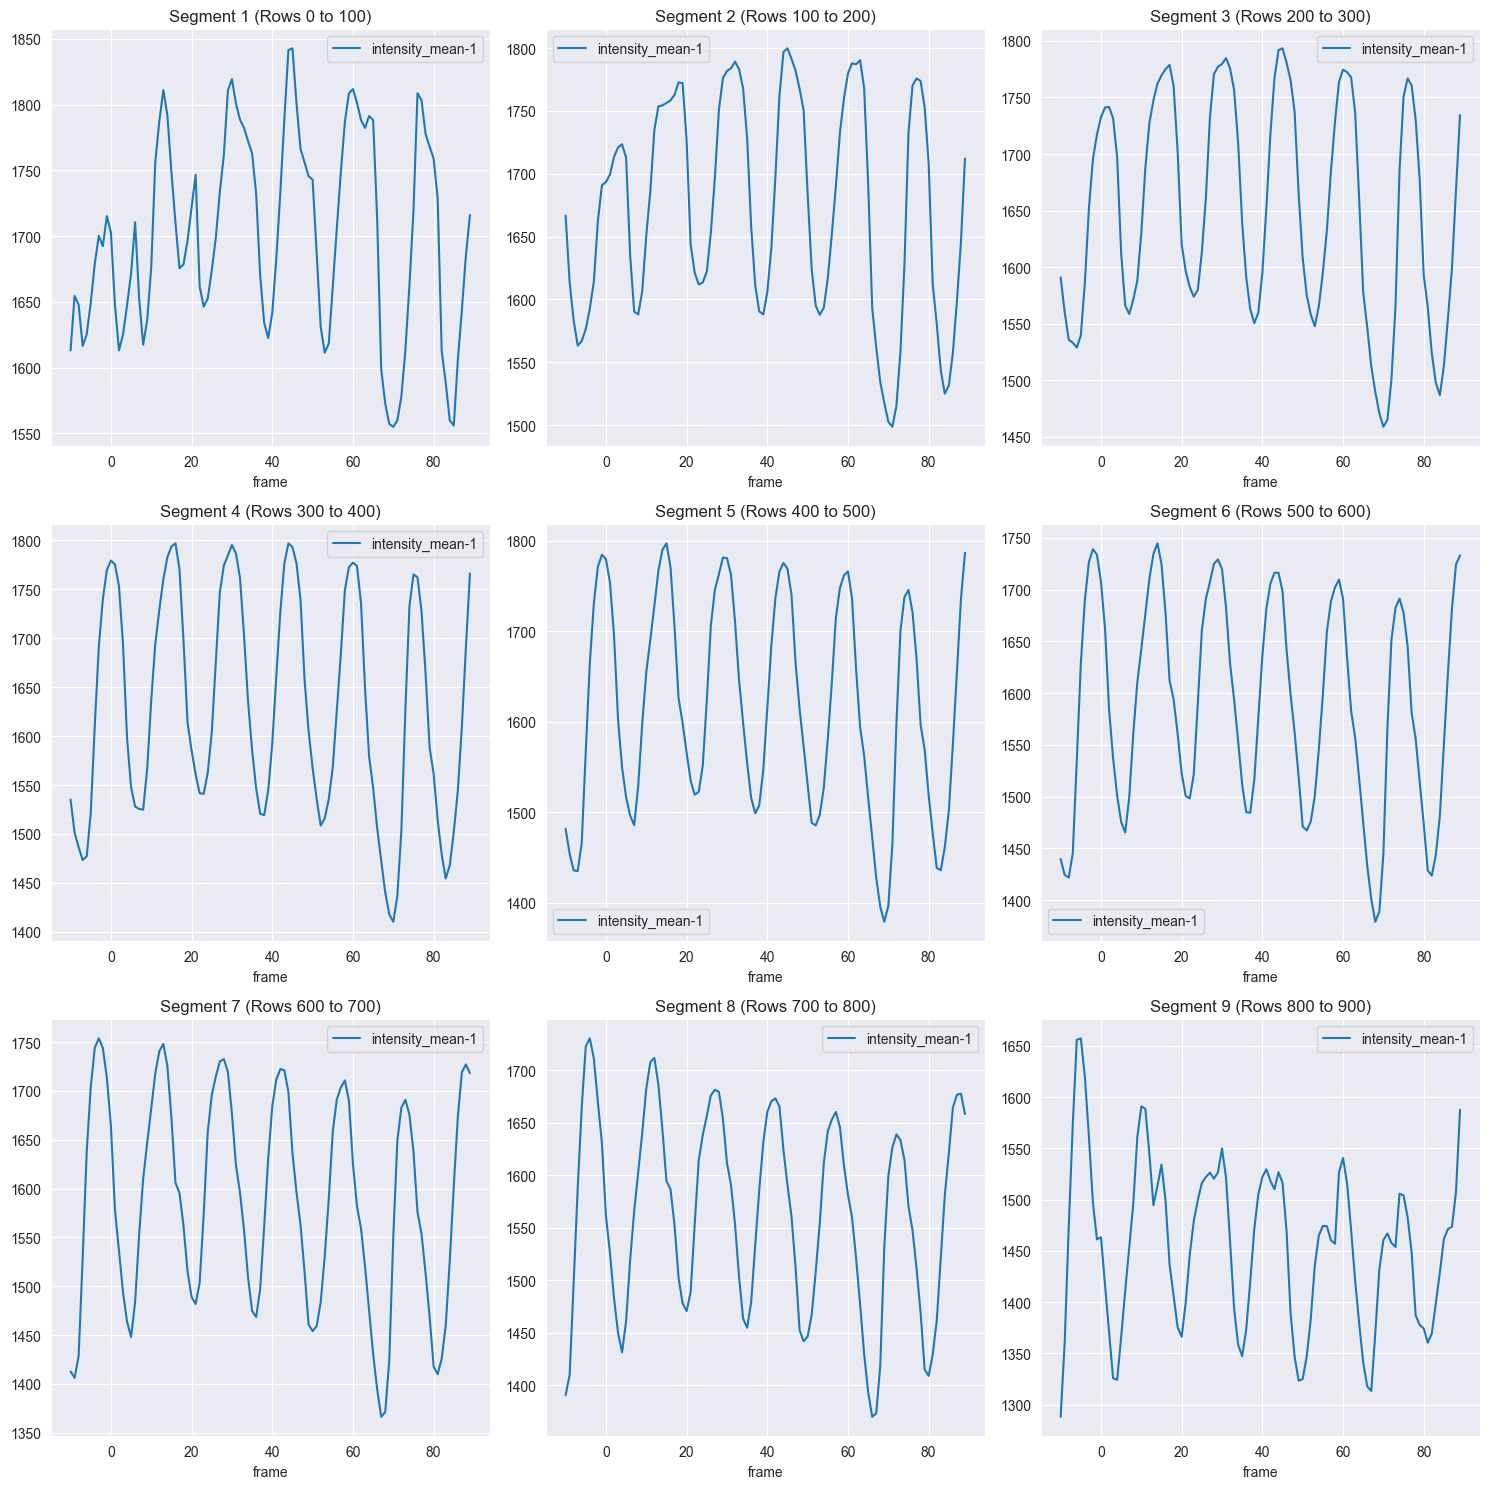

In [71]:
# Creating a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plotting the data in segments on the grid
for i, ax in enumerate(axes):
    start_row = i * 100
    end_row = start_row + 100
    df_all_several_frames.iloc[start_row:end_row].plot(x='frame', y='intensity_mean-1', ax=ax)
    ax.set_title(f'Segment {i+1} (Rows {start_row} to {end_row})')

plt.tight_layout()
plt.show()

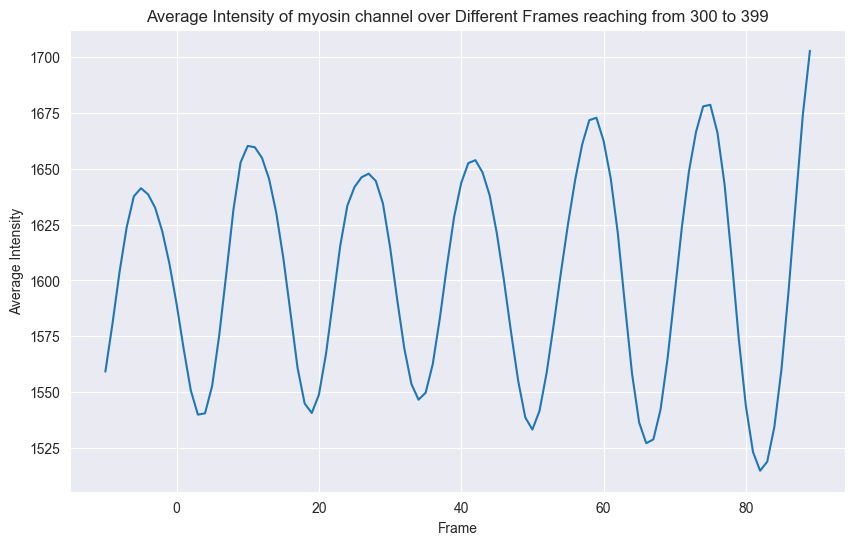

In [65]:
average_intensities_myosin = df_all_several_frames.groupby('frame')['intensity_mean-1'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_intensities_myosin.plot()

plt.title("Average Intensity of myosin channel over Different Frames reaching from 300 to 399")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
#plt.savefig("plots/average_intensity_actin.png")
plt.show()

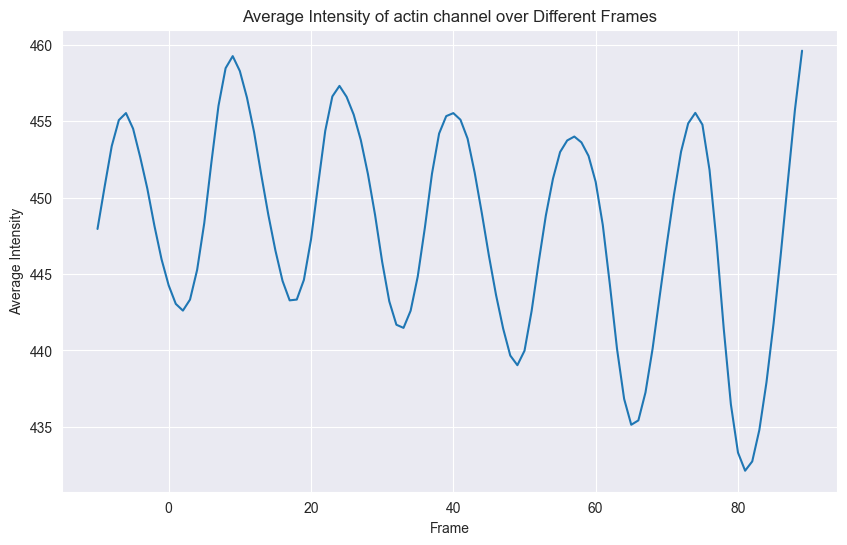

In [72]:
average_intensities_actin = df_all_several_frames.groupby('frame')['intensity_mean-0'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_intensities_actin.plot()

plt.title("Average Intensity of actin channel over Different Frames")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
#plt.savefig("plots/average_intensity_myosin.png")
plt.show()

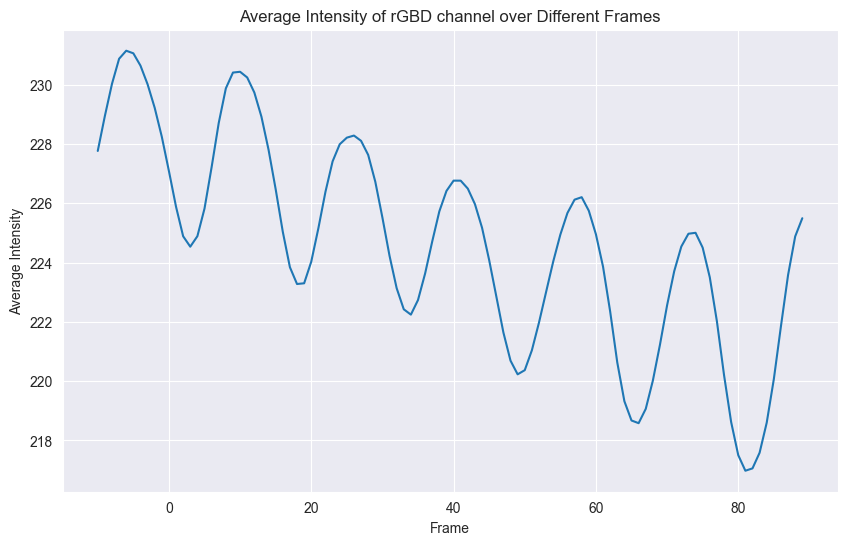

In [73]:
average_intensities_rgbd = df_all_several_frames.groupby('frame')['intensity_mean-2'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_intensities_rgbd.plot()

plt.title("Average Intensity of rGBD channel over Different Frames")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
#plt.savefig("plots/average_intensity_myosin.png")
plt.show()